In [1]:
# Preamble
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.labelsize'] = 20

from copy import deepcopy
from scipy import optimize

from dolo import *
import dolo.algos.perfect_foresight as pf
import dolo.algos.value_iteration as vi

import pandas as pd

# Since the Qmod class is in other folder we need to
# change the path.
import sys
sys.path.append('../')
from Qmod.Q_investment import Qmod

Since the plots for every experiment have the same format, I first define functions that carry out the analysis given a path for the exogenous variables.

In [2]:
# Function definitions
def pathValue(invest,mod1,mod2,k0,t):
    '''
    Computes the value of taking investment decisions [i(0),i(1),...,i(t-1)]
    starting at capital k0 and knowing that the prevailing model will switch
    from mod1 to mod2 at time t.

    Parameters:
        - invest: vector/list with investment values for periods 0 to t-1
        - mod1  : Qmod object representing the parameter values prevailing from
                  time 0 to t-1.
        - mod2  : Qmod object representing the parameter values prevailing from
                  time t onwards.
        - k0    : capital at time 0.
        - t     : time of the structural change.
    '''

    # Initialize capital and value (utility)
    k = np.zeros(t+1)
    k[0] = k0
    value = 0

    # Compute capital and utility flows until time t-1
    for i in range(t):
        flow = mod1.flow(k[i],invest[i])
        value += flow*mod1.beta**i
        k[i+1] = k[i]*(1-mod1.delta) + invest[i]

    # From time t onwards, model 2 prevails and its value function can be used.
    value += (mod1.beta**t)*mod2.value_func(k[t])

    return(value)

def structural_change(mod1,mod2,k0,t_change,T_sim,npoints = 300, figname = None,
                     labels = ['Pre-change','Post-change'], colors = ['r','b']):
    """
    Computes (optimal) capital and lambda dynamics in face of a structural
    change in the Q investment model.

    Parameters:
        - mod1    : Qmod object representing the parameter values prevailing
                    from time 0 to t_change-1.
        - mod2    : Qmod object representing the parameter values prevailing
                    from time t_change onwards.
        - k0      : initial value for capital.
        - t_change: time period at which the structural change takes place. It
                    is assumed that the change is announced at period 0.
        - T_sim   : final time period of the simulation.
        - npoints : number of points in the capital grid to be used for phase
                    diagram plots.
    """

    # If the change is announced with anticipation, the optimal path of
    # investment from 0 to t_change-1 is computed, as it does not correspond to
    # the usual policy rule.
    if t_change > 0:
        fobj = lambda x: -1*pathValue(x,mod1,mod2,k0,t_change)
        inv = optimize.minimize(fobj,x0 = np.ones(t)*mod1.kss*mod2.delta,
                                options = {'disp': True},
                                tol = 1e-16).x

    # Find paths of capital and lambda
    k = np.zeros(T_sim)
    lam = np.zeros(T_sim)
    invest = np.zeros(T_sim)
    
    k[0] = k0
    for i in range(0,T_sim-1):

        if i < t_change:
            # Before the change, investment follows the optimal
            # path computed above.
            k[i+1] = k[i]*(1-mod1.delta) + inv[i]
            lam[i] = mod1.findLambda(k[i],k[i+1])
            invest[i] = inv[i]
            
        else:
            # After the change, investment follows the post-change policy rule.
            k[i+1] = mod2.k1Func(k[i])
            lam[i] = mod2.findLambda(k[i],k[i+1])
            invest[i] = k[i+1] - (1-mod2.delta)*k[i]
            
    # Compute final period lambda and investment
    lam[T_sim-1] = mod2.findLambda(k[T_sim-1],mod2.k1Func(k[T_sim-1]))
    invest[T_sim-1] = mod2.k1Func(k[T_sim-1]) - (1-mod2.delta)*k[T_sim-1]
    
    # Get a vector with the post-itc price of capital, to calculate q
    Pcal = np.array([1-mod1.zeta]*t_change + [1-mod2.zeta]*(T_sim-t_change))
    
    # Compute q
    q = lam/Pcal
    
    # Create a figure with phase diagrams and dynamics.
    fig, ax = plt.subplots(3, 2, figsize=(15,12))
    
    # 1st plot: lambda phase diagrams
    
    # Plot k,lambda path.
    ax[0,0].plot(k,lam,'.k')
    ax[0,0].plot(k[t_change],lam[t_change],'.r',label = 'Change takes effect')

    # Plot the loci of the pre and post-change models.
    k_range = np.linspace(0.1*min(mod1.kss,mod2.kss),2*max(mod1.kss,mod2.kss),
                          npoints)
    mods = [mod1,mod2]

    for i in range(2):

        # Plot k0 locus
        ax[0,0].plot(k_range,mods[i].P*np.ones(npoints),
                     linestyle = '--', color = colors[i],label = labels[i])
        # Plot lambda0 locus
        ax[0,0].plot(k_range,[mods[i].lambda0locus(x) for x in k_range],
                     linestyle = '--', color = colors[i])
        # Plot steady state
        ax[0,0].plot(mods[i].kss,mods[i].P,marker = '*', color = colors[i])

    ax[0,0].set_xlabel('$k$')
    ax[0,0].set_ylabel('$\\lambda$')
    ax[0,0].legend()
    
    # 2nd plot: q phase diagrams
    
    # Plot k,lambda path.
    ax[0,1].plot(k,q,'.k')
    ax[0,1].plot(k[t_change],q[t_change],'.r',label = 'Change takes effect')

    # Plot the loci of the pre and post-change models.
    mods = [mod1,mod2]
    
    for i in range(2):

        # Plot k0 locus
        ax[0,1].plot(k_range,np.ones(npoints),
                     linestyle = '--', color = colors[i],label = labels[i])
        # Plot q0 locus
        ax[0,1].plot(k_range,[mods[i].lambda0locus(x)/mods[i].P for x in k_range],
                     linestyle = '--', color = colors[i])
        # Plot steady state
        ax[0,1].plot(mods[i].kss,1,marker = '*', color = colors[i])

    ax[0,1].set_xlabel('$k$')
    ax[0,1].set_ylabel('$q$')
    ax[0,1].legend()
    
    # 3rd plot: capital dynamics
    time = range(T_sim)
    ax[1,0].plot(time,k,'.k')
    ax[1,0].set_xlabel('$t$')
    ax[1,0].set_ylabel('$k_t$')
    
    # 4rd plot: lambda dynamics
    ax[1,1].plot(time,lam,'.k')
    ax[1,1].set_xlabel('$t$')
    ax[1,1].set_ylabel('$\\lambda_t$')
    
    # 5th plot: investment dynamics
    ax[2,0].plot(time,invest,'.k')
    ax[2,0].set_xlabel('$t$')
    ax[2,0].set_ylabel('$i_t$')
    
    # 6th plot: q dynamics
    ax[2,1].plot(time,q,'.k')
    ax[2,1].set_xlabel('$t$')
    ax[2,1].set_ylabel('$q_t$')
    
    if figname is not None:
        fig.savefig('../Figures/'+figname+'.svg')
        fig.savefig('../Figures/'+figname+'.png')
        fig.savefig('../Figures/'+figname+'.pdf')
    
    return({'k':k, 'lambda':lam})

In [3]:
# Base parameters

# Discount factor and return factor
beta = 0.98
R = 1/beta

# Tax rate
tau = 0.0

# Share of capital in production
alpha = 0.33

# Adjustment costs
omega = 1

# Investment tax credit
zeta = 0

# Depreciation rate
delta = 0.1

# Technological factor
psi = 1


## Qmod python class
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
Qmodel.solve()

## Questions

1. Leading up to date $t$, the economy is in steady state.  At date $t$, the government unexpectedly introduces a permanent increase in the corporate tax rate, $\tau \uparrow$.  Show the effects on a phase diagram and show dynamics of investment, capital, share prices, and $\q$ following the tax change.  In particular explain what, if anything, happens to $\vk$, the share price of the firm, when the $\taxCorp$ is implemented.

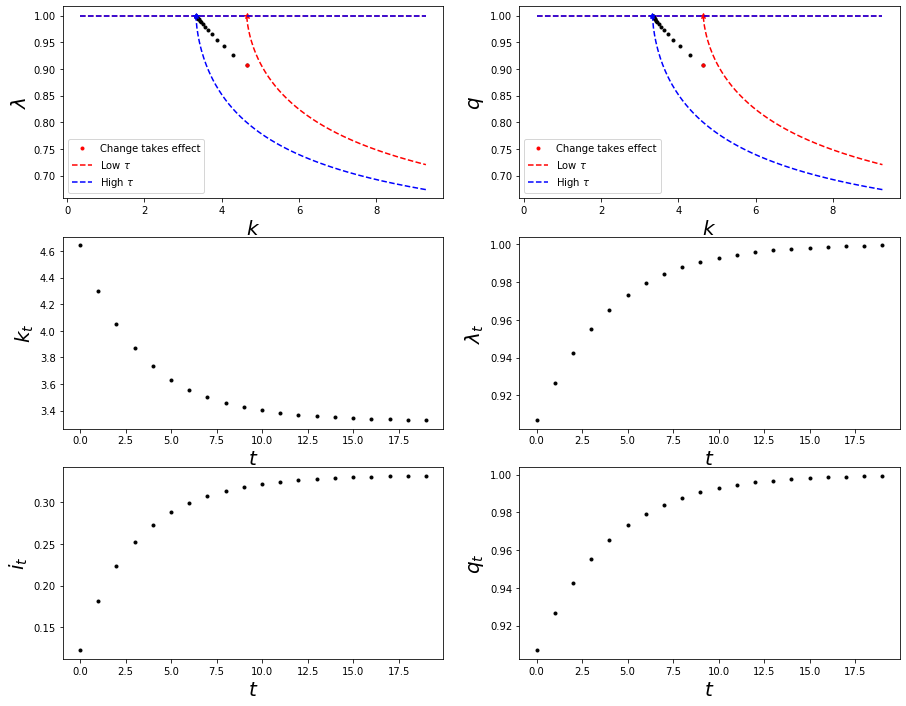

In [4]:
figname = 'ExamQ1'

# Total simulation time
T = 20
# Time the change occurs
t = 0
# Initial level of capital
k0 = Qmodel.kss

# Productivity in the "new" state
tau_high = 0.2

# Copy the initial model, set the higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.tau = tau_high
Q_high_tau.solve()

labels = ['Low $\\tau$','High $\\tau$']
colors = ['r','b']
sol = structural_change(mod1 = Qmodel, mod2 = Q_high_tau,
                        k0 = k0, t_change = t,T_sim=T,
                       figname = figname, labels = labels, colors = colors)

2. Leading up to date $t$, the economy is in steady state.  At date $t$, the government unexpectedly introduces a \textit{temporary} increase in the corporate tax rate, $\tau \uparrow$.  The high $\taxCorp$ will last for two years, and then the $\taxCorp$ will revert back to its normal level.  Show the effects on a phase diagram and show dynamics of investment, capital, share prices, and $\q$, and the capital stock under two scenarios: (1) costs of adjustment for the capital stock, $\omega$, are high; (2) costs of adjustment are low.  EXPLAIN your results.

         Current function value: -59.584005
         Iterations: 6
         Function evaluations: 276
         Gradient evaluations: 67


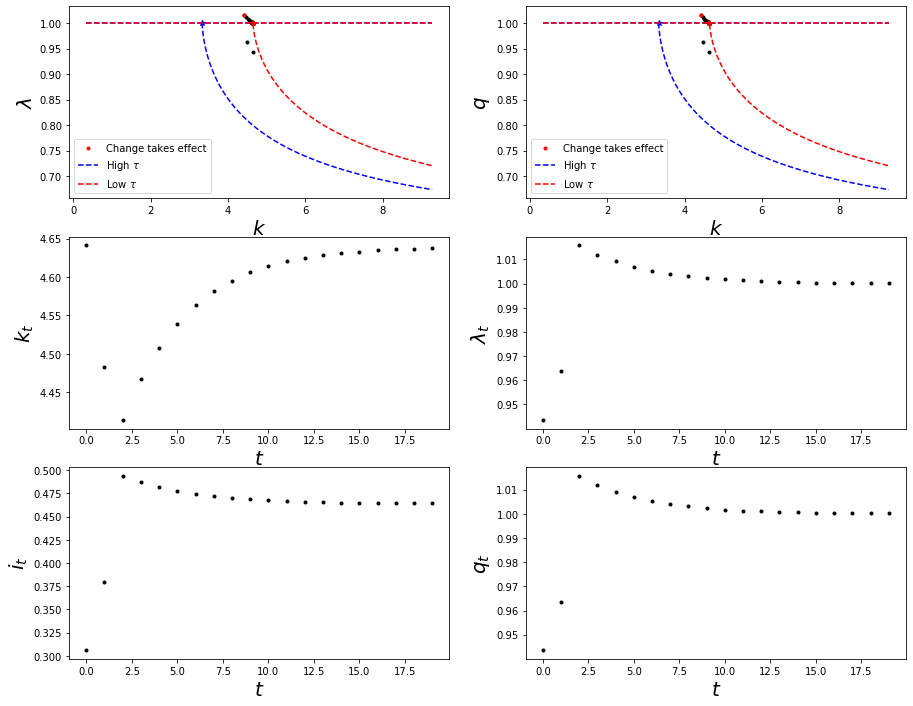

In [5]:
figname = 'ExamQ2'

# Total simulation time
T = 20
# Time the change occurs
t = 2
# Initial level of capital
k0 = Qmodel.kss

labels = ['High $\\tau$','Low $\\tau$']
colors = ['b','r']
sol = structural_change(mod1 = Q_high_tau, mod2 = Qmodel,
                        k0 = k0, t_change = t,T_sim=T,
                       figname = figname, labels = labels, colors = colors)

3. Leading up to date $t$, the economy is in steady state, and a $\taxCorp$ of 20 percent has existed since the beginning of time.  At date $t$, the government unexpectedly \textit{announces} that in three years (that is, in year $t+3$), there will be a \textit{permanent} decrease in the corporate tax rate, $\tau \uparrow \bar{\tau}$.  Show and explain the effects on a phase diagram and show dynamics of investment, capital, share prices, and $\q$, and the capital stock under two scenarios: (1) costs of adjustment for the capital stock, $\omega$, are high; (2) costs of adjustment are low.  EXPLAIN your results.

Optimization terminated successfully.
         Current function value: -57.964641
         Iterations: 11
         Function evaluations: 75
         Gradient evaluations: 15


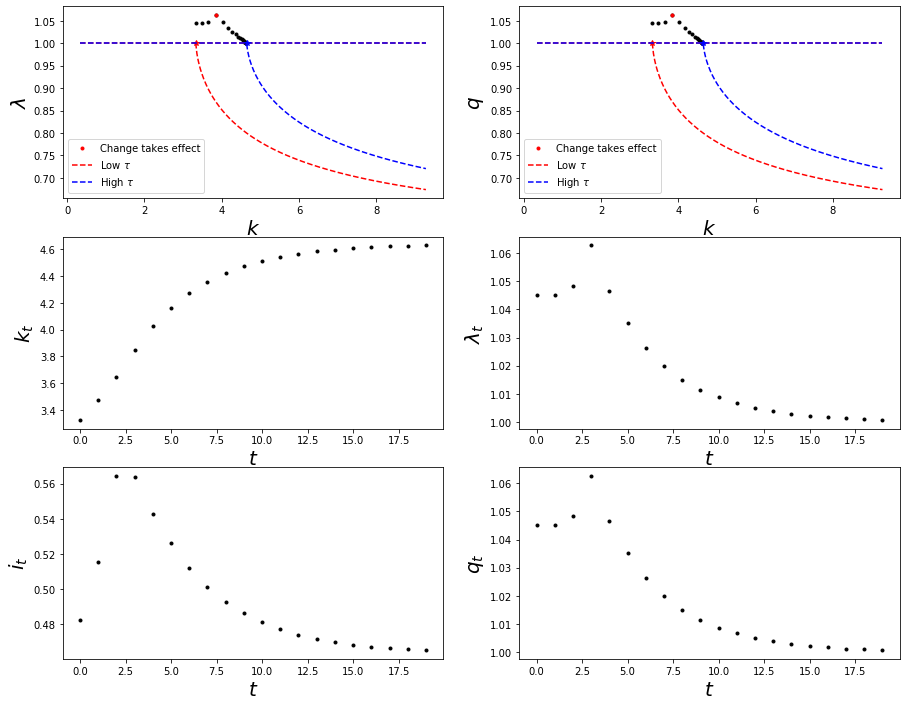

In [6]:
figname = 'ExamQ3'

# Total simulation time
T = 20
# Time the change occurs
t = 3
# Initial level of capital
k0 = Q_high_tau.kss

labels = ['Low $\\tau$','High $\\tau$']
colors = ['r','b']
sol = structural_change(mod1 = Q_high_tau, mod2 = Qmodel,
                        k0 = k0, t_change = t,T_sim=T,
                        figname = figname, labels = labels, colors = colors)